In [57]:
%pylab inline
%run params.py

import matplotlib.pyplot as plt
import pandas as pd
import random
import os
from scipy.stats import pearsonr
import matplotlib as mpl
mpl.rcParams['pdf.fonttype'] = 42
from plotting_functions import *
from scipy.stats import ks_2samp

Populating the interactive namespace from numpy and matplotlib


`%matplotlib` prevents importing * from pylab and numpy


In [58]:
# Load data
dataset = pd.read_csv(os.path.join(DATAPATH, "constraint", "autosomal_perlocus_estimates.bed"))

# 4A Expression by tissue

In [59]:
# Look at expression by tissue
gtex = pd.read_csv(os.path.join(DATAPATH,"strsets","GTEx_Analysis_v6p_RNA-seq_RNA-SeQCv1.1.8_gene_median_rpkm.gct.gz"),
                  skiprows=2, sep="\t")
exprcols = [item for item in gtex.columns if item not in ["Description","Name"]]
gtex["gene"] = gtex["Description"]

setdata = pd.read_csv(os.path.join(DATAPATH, "strsets", "lobSTR_ref_GRCh37_coding_genes.bed.gz"), sep="\t", names=["chrom","start","end","gene"])
setdata = pd.merge(setdata, dataset, on=["chrom","start"]).drop_duplicates()
data = pd.merge(setdata, gtex, on=["gene"])
exprmatrix = data.loc[:,exprcols]

In [60]:
col="zscore_1"

corr = []
pvals = []
means = []
nums = []
kspvals = []
kspvals_ctrl = []
threshold = 80 # top X% of expressed genes

for tissue in exprcols:
    r = pearsonr(data[data[tissue]>0][col], data[data[tissue]>0][tissue])
    corr.append(r[0])
    pvals.append(r[1])
    means.append(np.mean(data[data[tissue]>0][col]))
    nums.append(data[data[tissue]>0].shape[0])
    
    # zscores for top 10%
    cutoff = np.percentile(data[data[tissue]>0][tissue], [threshold])[0]
    zhigh = data[data[tissue]>0][data[tissue]>cutoff][col]
    zlow = data[data[tissue]>0][data[tissue]<=cutoff][col]
    print tissue, cutoff, np.mean(zhigh)-np.mean(zlow), len(zhigh), len(zlow)
    #print data.shape[0], len(zhigh), len(zlow), len(zhigh)+len(zlow)
    kspvals.append(ks_2samp(zhigh, zlow)[1])
    
    # Repeat, with expression shuffled
    rexpr = data[tissue].copy()
    random.shuffle(rexpr)
    zhigh = data[rexpr>cutoff][col]
    zlow = data[rexpr<=cutoff][col]
    kspvals_ctrl.append(ks_2samp(zhigh, zlow)[1])    
    
cdata = pd.DataFrame({"tissue": exprcols, "corr": corr, "pval": pvals, "meanz": means,"num":nums,
                      "ksp":kspvals, "ksp_ctrl": kspvals_ctrl})
cdata["corr2"] = cdata["corr"].apply(lambda x: x**2)
cdata = cdata[["tissue","corr","corr2","pval","meanz","num","ksp","ksp_ctrl"]]

Adipose - Subcutaneous 12.392 0.0462716609759 282 1128
Adipose - Visceral (Omentum) 11.95 0.0594517385005 281 1125
Adrenal Gland 11.23 -0.197621109812 280 1118
Artery - Aorta 12.996 -0.0299762070764 278 1109
Artery - Coronary 12.708 -0.149448290441 279 1114
Artery - Tibial 13.05 -0.0895685561724 274 1097
Bladder 14.36 -0.0644719475237 279 1118
Brain - Amygdala 8.9864 -0.541657284469 286 1141
Brain - Anterior cingulate cortex (BA24) 10.076 -0.541594332421 288 1150
Brain - Caudate (basal ganglia) 9.6782 -0.604101172761 287 1146
Brain - Cerebellar Hemisphere 15.36 -0.69622277746 285 1141
Brain - Cerebellum 15.858 -0.538490456716 286 1141
Brain - Cortex 11.82 -0.627460901861 288 1151
Brain - Frontal Cortex (BA9) 11.64 -0.633831913457 287 1148
Brain - Hippocampus 9.211 -0.378844065667 287 1147
Brain - Hypothalamus 9.995 -0.41536451842 291 1163
Brain - Nucleus accumbens (basal ganglia) 10.13 -0.660901790529 288 1144
Brain - Putamen (basal ganglia) 8.772 -0.547826625839 286 1142
Brain - Spina

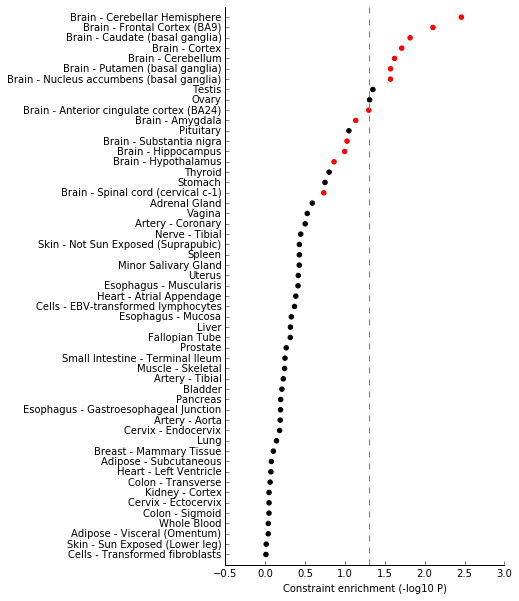

In [61]:
colors = {}
for tissue in exprcols:
    if "Brain" in tissue: colors[tissue] = "red"

cdata["color"] = cdata["tissue"].apply(lambda x: colors.get(x, "black"))
cdata = cdata.sort("ksp", ascending=False)
cdata["order"] = range(cdata.shape[0])
fig = plt.figure()
fig.set_size_inches((5,10))
ax = fig.add_subplot(111)
ax.scatter(np.log10(cdata["ksp"])*-1, cdata["order"], color=cdata["color"])
ax.axvline(x=-1*np.log10(0.05), linestyle="dashed", color="gray")
ax.set_ylim(bottom=-1, top=cdata.shape[0])
ax.spines["top"].set_visible(False);
ax.spines["right"].set_visible(False);
ax.get_xaxis().tick_bottom();
ax.get_yaxis().tick_left();
ax.set_yticks(cdata["order"])
ax.set_yticklabels(cdata["tissue"]);
ax.set_xlabel("Constraint enrichment (-log10 P)")
fig.savefig(os.path.join(PLOTDIR, "Figure4_ConstraintExpression.pdf"))

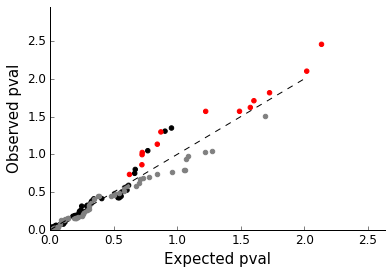

In [62]:
cdata = cdata.sort("ksp_ctrl")
ctrl = -1*np.log10(cdata["ksp_ctrl"])
exp2 = -1*np.log10(sorted(np.random.uniform(size=cdata.shape[0])))
cdata = cdata.sort("ksp")
exp = -1*np.log10(sorted(np.random.uniform(size=cdata.shape[0])))
obs = -1*np.log10(cdata["ksp"])
fig = plt.figure()
ax = fig.add_subplot(111)
ax.scatter(exp, obs, color=cdata["color"])
ax.scatter(exp2, ctrl, color="gray")
ax.plot([0,2],[0,2], color="black", linestyle="dashed")
ax.set_xlim(left=0, right=max(exp)+0.5)
ax.set_ylim(bottom=0, top=max(obs)+0.5)
ax.spines["top"].set_visible(False);
ax.spines["right"].set_visible(False);
ax.get_xaxis().tick_bottom();
ax.get_yaxis().tick_left();
ax.set_xlabel("Expected pval", size=15)
ax.set_ylabel("Observed pval", size=15)
ax.set_xticklabels(ax.get_xticks(), size=12)
ax.set_yticklabels(ax.get_yticks(), size=12);
fig.savefig(os.path.join(PLOTDIR, "SupplementalFigure15_GTExQQ.pdf"))

# 4B Example loci - CODIS/disease/autism

/usr/local/lib/python2.7/site-packages/ipykernel/__main__.py:43: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/usr/local/lib/python2.7/site-packages/ipykernel/__main__.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/usr/local/lib/python2.7/site-packages/ipykernel/__main__.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexi

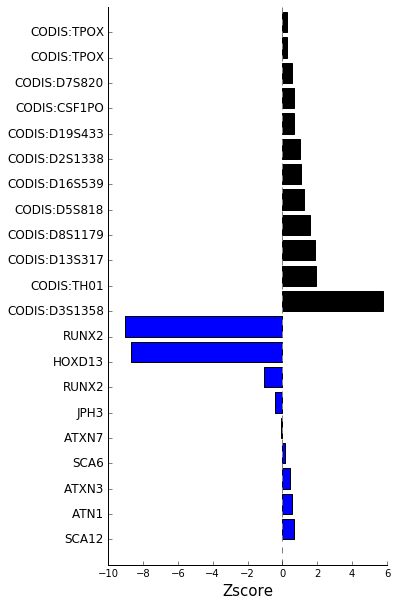

In [63]:
# Load CODIS/disease loci

col = "zscore_1"

loci = pd.read_csv(os.path.join(DATAPATH, "strsets", "loci_for_figure.bed"), names=["chrom","start","end","marker"], sep="\t")
loci = pd.merge(dataset, loci, on=["chrom","start","end"])

def GetColor(x):
    if "CODIS" in x["marker"]: return "black"
    else: return "blue"

def GetCat(x):
    if "CODIS" in x["marker"]: return "A_CODIS"
    else: return "C_DISEASE"
        
loci = loci.sort("marker")
loci["color"] = loci.apply(lambda x: GetColor(x), 1)
loci["cat"] = loci.apply(lambda x: GetCat(x), 1)
loci = loci.sort("marker")
rm = loci[loci["start"] == 45582231]
loci = loci[loci["start"] != 45582231]
loci = pd.concat([loci, rm.iloc[0:1,:]])
loci["gene"] = "NA"

# Load marshfield
#marsh = pd.read_csv(os.path.join(DATAPATH, "strsets","marshfield_loci.bed"), names=["chrom","start","end","period","marker"], sep="\t")
#marsh = pd.merge(dataset, marsh, on=["chrom","start","end"])
#marsh["color"] = "purple"
#marsh["gene"] = "NA"
#marsh["marker"] = marsh["marker"].apply(lambda x: "B_Marshfield:%s"%x)
#loci = pd.concat([loci, marsh])

# Load autism
coding = pd.read_csv(os.path.join(DATAPATH, "strsets", "lobSTR_ref_GRCh37_coding_genes.bed.gz"), sep="\t", names=["chrom","start","end","gene"])
coding = pd.merge(coding, dataset, on=["chrom","start","end"]).drop_duplicates()
#coding = coding[coding["gene"].apply(lambda x: "." not in x and "-AS" not in x)]
autism = (pd.read_csv(os.path.join(DATAPATH, "strsets","autism_sfari_genes_bycategory.csv")))
autism["gene"] = autism["Gene Symbol"]

for category in ["1","2"]: #,"3","4","5"]:
    autism_genes = set(autism[autism["category"].apply(lambda x: category in str(x))]["Gene Symbol"])
    newloci = coding[coding.apply(lambda x: x["gene"] in autism_genes, 1)]
    newloci["cat"] = "D_Autism:%s"%category
    newloci["color"] = "blue"
    newloci["marker"] = newloci["gene"]
    #loci = pd.concat([loci, newloci])

# Add top and bottom to list
coding["cat"] = "E_coding"
coding["marker"] = coding["gene"]
coding["color"] = "green"
#loci = pd.concat([loci, coding.sort("diff_1").head(n=5)])
#loci = pd.concat([loci, coding.sort("diff_1").tail(n=5)])
    
loci = loci.sort(["cat",col], ascending=False)
fig = plt.figure()
fig.set_size_inches((5, 10))
ax = fig.add_subplot(111)
ax.barh(range(loci.shape[0]), loci["zscore_1"], color=loci["color"])
ax.spines["top"].set_visible(False);
ax.spines["right"].set_visible(False);
ax.get_xaxis().tick_bottom();
ax.get_yaxis().tick_left();
ax.axvline(0, linestyle="dashed", color="gray")
ax.set_ylim(bottom=-1, top=loci.shape[0]);
ax.set_yticks(range(loci.shape[0]));
ax.set_yticklabels(loci["marker"], size=12);
ax.set_xlabel("Zscore", size=15);
fig.savefig(os.path.join(PLOTDIR, "Figure4_ConstraintExamples.pdf"))

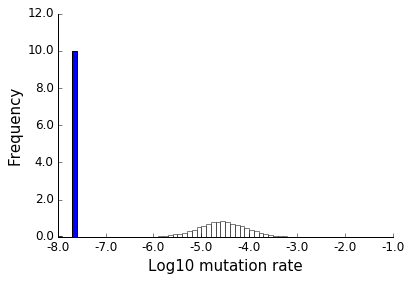

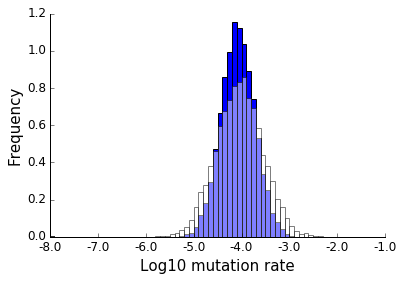

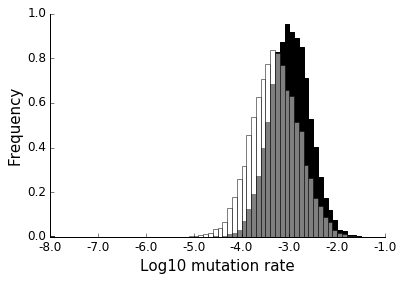

In [64]:
starts = [45390419, 63898361, 30417141]
colors = ["blue","blue","black"]
xvals = np.arange(-8, -1, 0.1)

for i in range(len(starts)):
    x = loci[loci["start"]==starts[i]]
    color = colors[i]
    
    obs_mu = x["ml_mu"].values[0]
    obs_mu_se = x["ml_mu_stderr"].values[0]
    if obs_mu_se <= 0: obs_mu_se = 0.001
    exp_mu = x["pred_mu_1"].values[0]
    exp_mu_se = x["pred_mu_se_1"].values[0]
    
    obs = np.random.normal(loc=obs_mu, scale=obs_mu_se, size=10000)
    exp = np.random.normal(loc=exp_mu, scale=exp_mu_se, size=10000)

    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.hist(obs, bins=xvals, color=color, lw=1, normed=True);
    ax.hist(exp, bins=xvals, color="white", lw=1, edgecolor="black", normed=True, alpha=0.5);
    ax.spines["top"].set_visible(False);
    ax.spines["right"].set_visible(False);
    ax.get_xaxis().tick_bottom();
    ax.get_yaxis().tick_left();
    ax.set_xticklabels(ax.get_xticks(), size=12)
    ax.set_yticklabels(ax.get_yticks(), size=12)
    ax.set_xlabel("Log10 mutation rate", size=15)
    ax.set_ylabel("Frequency", size=15);
    fig.savefig(os.path.join(PLOTDIR, "Figure4_Example_%s.pdf"%starts[i]))

# GO analysis

In [78]:
# Download files
from goatools.base import download_go_basic_obo
from goatools.base import download_ncbi_associations
from goatools.obo_parser import GODag
from goatools.associations import read_ncbi_gene2go
from goatools.go_enrichment import GOEnrichmentStudy
obo_fname = download_go_basic_obo()
gene2go = download_ncbi_associations()

# Load data
obodag = GODag("go-basic.obo")
geneid2gos_human = read_ncbi_gene2go("gene2go", taxids=[9606])

# Load coding
coding = pd.read_csv(os.path.join(DATAPATH, "strsets", "lobSTR_ref_GRCh37_coding_genes.bed.gz"), sep="\t", names=["chrom","start","end","gene"])
coding = pd.merge(coding, dataset, on=["chrom","start","end"]).drop_duplicates()

  EXISTS: go-basic.obo
  EXISTS: gene2go
load obo file go-basic.obo
go-basic.obo: fmt(1.2) rel(2016-11-26) 47,820 GO Terms


In [79]:
sys.path.append("/Users/gymrek/workspace/goatools/goatools/test_data/")
from genes_NCBI_9606_ProteinCoding import GeneID2nt
geneSymbolToID = {}
strgenes = set(coding["gene"])
for geneid in GeneID2nt.keys():
    nt = GeneID2nt.get(geneid)
    symbol = nt.Symbol
    if symbol in strgenes:
        geneSymbolToID[symbol] = geneid
background_ids = geneSymbolToID.values()
all_human_ids = GeneID2nt.keys()
coding["geneid"] = coding["gene"].apply(lambda x: geneSymbolToID.get(x, -1))

In [80]:
# Enrichment of STR genes in general
goeaobj = GOEnrichmentStudy(
        all_human_ids, # List of human protein-coding genes
        geneid2gos_human, # geneid/GO associations
        obodag, # Ontologies
        propagate_counts = True,
        alpha = 0.05, # default significance cut-off
        methods = ['fdr_bh']) # defult multipletest correction method
goea_results_all = goeaobj.run_study(background_ids)
goeaobj.wr_txt("all_str_genes.txt", goea_results_all)

fisher module not installed.  Falling back on scipy.stats.fisher_exact


Propagating term counts to parents ..


18,332 out of 20,913 population items found in association
Calculating uncorrected p-values using fisher_scipy_stats
 1,090 out of  1,141 study items found in association
Running multitest correction: statsmodels fdr_bh
  8,205 GO terms are associated with 1,090 of 1,141 study items
  20,916 GO terms are associated with 18,332 of 20,913 population items
  20916 items WROTE: all_str_genes.txt


In [81]:
# Initialize GOEA object
goeaobj = GOEnrichmentStudy(
        background_ids, # List of human protein-coding genes
        geneid2gos_human, # geneid/GO associations
        obodag, # Ontologies
        propagate_counts = True,
        alpha = 0.05, # default significance cut-off
        methods = ['fdr_bh']) # defult multipletest correction method

fisher module not installed.  Falling back on scipy.stats.fisher_exact


Propagating term counts to parents ..


 1,090 out of  1,141 population items found in association


In [82]:
# Enrichment of top and bottom constrained genes
top_constrained = list(coding[coding["geneid"]!=-1][coding["ml_mu"] < -7]["geneid"].values)
bottom_constrained = list(coding[coding["geneid"]!=-1][coding["diff_1"] > 0]["geneid"].values)

goea_results_all = goeaobj.run_study(top_constrained)
goeaobj.wr_txt("top_constrained.txt", goea_results_all)

goea_results_all = goeaobj.run_study(bottom_constrained)
goeaobj.wr_txt("bottom_constrained.txt", goea_results_all)

Calculating uncorrected p-values using fisher_scipy_stats
   850 out of    891 study items found in association


ValueError: All values in `table` must be nonnegative.

In [ ]:
coding = pd.read_csv(os.path.join(DATAPATH, "strsets", "lobSTR_ref_GRCh37_coding_genes.bed.gz"), sep="\t", names=["chrom","start","end","gene"])
coding = pd.merge(coding, dataset, on=["chrom","start","end"]).drop_duplicates()
autism = (pd.read_csv(os.path.join(DATAPATH, "strsets","autism_sfari_genes_bycategory.csv")))
autism["gene"] = autism["Gene Symbol"]
autism = pd.merge(coding, autism, on="gene")
autism[autism["category"].apply(lambda x: "1" in x)]